In [721]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm 

In [722]:
class StochasticSIR:
    def __init__(self, initial_SIR, beta, gamma, tmax, mu=0):
        self.current_SIR = initial_SIR
        self.SIR = self.initialize()
        self.beta = beta
        self.gamma = gamma
        self.t = [0]
        self.tmax = tmax
        self.mu = mu

    def initialize(self):
        """
        Changes self.current_SIR to a dictionary, each value in the original list being assigned to the corresponding key in the new dictionary, being either 'S', 'I', ''R' or 'N'.
        Creates and returns dictionary with lists for S, I, R, and N. By default, N is the sum of the subpopulations.
        """ 
        S, I, R = self.current_SIR
        self.current_SIR = {'S': S, 'I': I, 'R': R, 'N': S + I + R}
        return {'S': [S], 'I': [I], 'R': [R], 'N': [S + I + R]}

    def infection_event(self):
        """
        Infection event: decreases susceptible population and increase infected population by 1
        """
        
        self.current_SIR['S'] -= 1
        self.current_SIR['I'] += 1

    def recovery_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['I'] -= 1
        self.current_SIR['R'] += 1

    def birth_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['S'] += 1

    def susceptible_death_event(self):

        self.current_SIR['S'] -= 1

    def infected_death_event(self):

        self.current_SIR['I'] -= 1

    def recovered_death_event(self):

        self.current_SIR['R'] -= 1

    def update_SIR(self):
        """
        Updates the dictionary containing the dynamics according to the most recent status of the simulation.
        """ 

        S, I, R, N = self.current_SIR.values()
        self.SIR['S'].append(S)
        self.SIR['I'].append(I)
        self.SIR['R'].append(R)
        self.SIR['N'].append(S + I + R)

    def run(self):
        """
        Runs a simulation of the SIR model using the Gillespie algorithm until a specified
        maximum time (tmax) is reached or until the infected population (I) becomes zero, whichever
        occurs first.

        The Gillespie algorithm is used to model stochastic events, being the disease transmission and recovery.
        During each time step, the following steps are performed:
        1. Get the most recent values of susceptible (S), infected (I), recovered (R), and total population (N).
        2. Calculate the probabilities of two events:
        - Event 1: A single infection.
        - Event 2: A single recovery.
        3. Calculate the length of the current time step (dt) based on exponential distributions
        and the sum of event probabilities.
        4. Advance the simulation time (t) by adding dt to the previous time.
        5. Perform either an infection event or a recovery event based on generated probabilities.
        6. Update the dictionary containing all the disease dynamics.
        """

        # Until tmax is reached. Number of timesteps is unknown, so for-loop is not useful
        while self.t[-1] < self.tmax:

            # Get most recent values of S, I, R and N
            S, I, R, N = self.current_SIR.values()

            # Stop simulation if infected population reaches zero
            if self.mu == 0 and I == 0:
                dt = self.tmax - self.t[-1]
                self.t.append(self.tmax)

            else:

                # Calculate probabilities of event 1 (single infection) and event 2 (single recovery)
                probabilities = [self.beta * S * I / N, self.gamma * I, self.mu *N , self.mu * S, self.mu * I, self.mu * R]
                probabilities_sum = sum(probabilities)
                cumulative_probabilities = [sum(probabilities[:i+1]) for i in range (len(probabilities))]

                # Calculate length current timestep and add it to self.t
                dt= np.random.exponential(scale = 1 / probabilities_sum)
                self.t.append(self.t[-1] + dt)


                P = np.random.uniform(0, 1) * probabilities_sum

                # Do infection or recovery event according to probabilities
                if P < cumulative_probabilities[0]:

                    # 1 susceptible becomes infected
                    self.infection_event()

                # 1 infected becomes recovered
                elif P < cumulative_probabilities[1]:
                    self.recovery_event()

                elif P < cumulative_probabilities[2]:
                    self.birth_event()

                elif P < cumulative_probabilities[3]:
                    self.susceptible_death_event()
                
                elif P < cumulative_probabilities[4]:
                    self.infected_death_event()

                elif P <= cumulative_probabilities[5]:
                    self.recovered_death_event()

            # Update dictionary containing all dynamics
            self.update_SIR()


    def plot(self, ax, std=None, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered', label=False):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """
        if label:
            label_addition = " stochastic"
        else:
            label_addition = ""
            
        # If the susceptible curve is to be plotted
        if S:
            y = self.SIR['S']
            ax.plot(self.t, y, label=f"{S_label}{label_addition}", color='blue', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['S'], y + std['S'], alpha=0.2, color='blue')

        # If the infected curve is to be plotted
        if I:
            y = self.SIR['I']
            ax.plot(self.t, y, label=f"{I_label}{label_addition}", color='green', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['I'], y + std['I'], alpha=0.2, color='green')

        # If the recovered curve is to be plotted
        if R:
            y = self.SIR['R']
            ax.plot(self.t, y, label=f"{R_label}{label_addition}", color='purple', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['R'], y + std['R'], alpha=0.2, color='purple')

        # If the population size curve is to be plotted
        if N:
            ax.plot(self.t, self.SIR['N'], label=f'Population size{label_addition}', color='orange', linewidth='1')

In [723]:
class ContinuousSIR:
    def __init__(self, initial_SIR, tmax, dt, beta, gamma, mu=0):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.tmax = tmax
        self.dt = dt
        self.population_size = sum(initial_SIR)
        self.n_points = int(tmax/dt)
        self.t = np.linspace(0, self.tmax, self.n_points)
        self.sir = self.initiate(initial_SIR)

    def initiate(self, initial_SIR):
        """
        Initiales the array where the results will be stored. Fills in start conditions.
        """ 

        SIR = np.zeros([len(self.t), 4])
        S, I, R = initial_SIR
        N = S + I + R
        SIR[0] = np.array([[S/N, I/N, R/N, N]])
        return SIR

    def get_derivatives(self, y):
        """
        Calculates the time derivative of S, I, and R in the SIR model according to the current values of S I and R, and the values of beta, gamma, mu, nu and rho.
        """

        # Unpack parameters from array
        S, I, R, N = y
        
        dS = self.mu - self.beta * S * I - self.mu * S
        dI = self.beta * S * I - self.gamma * I - self.mu * I
        dR = self.gamma * I - self.mu * R
        dN = dS + dI + dR

        # Return array with values for the time derivatives of S, I, and R. Sets value for N to 0, this will be calculated and adjusted in run()
        return np.array([dS, dI, dR, dN])

    def run(self):
        """
        Numerically approximates the set of differential equations of the SIR model according to the 4th order Runge-Kutta method.
        """

        # For each timestep
        for i in range(len(self.t) - 1):

            # Do timestep according to Runge-Kutta 4th order
            y = self.sir[i]
            k_1 = self.dt * self.get_derivatives(y)
            k_2 = self.dt * self.get_derivatives(y + k_1 / 2.)
            k_3 = self.dt * self.get_derivatives(y + k_2 / 2.)
            k_4 = self.dt * self.get_derivatives(y + k_3)

            # Update values for S, I, R and N
            self.sir[i+1] = y + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
            
        return self.sir

    def plot(self, ax, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered'):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """

        if S:
            ax.plot(self.t, self.population_size * self.sir[:,0], '--', label=f"{S_label} continuous", color='blue', linewidth='1')
        if I:
            ax.plot(self.t, self.population_size * self.sir[:,1], '--', label=f"{I_label} continuous", color='green', linewidth='1')
        if R:
            ax.plot(self.t, self.population_size * self.sir[:,2], '--', label=f"{R_label} continuous", color='purple', linewidth='1')
        if N:
            ax.plot(self.t, self.sir[:,3], '--', label='Population size continuous', color='orange')


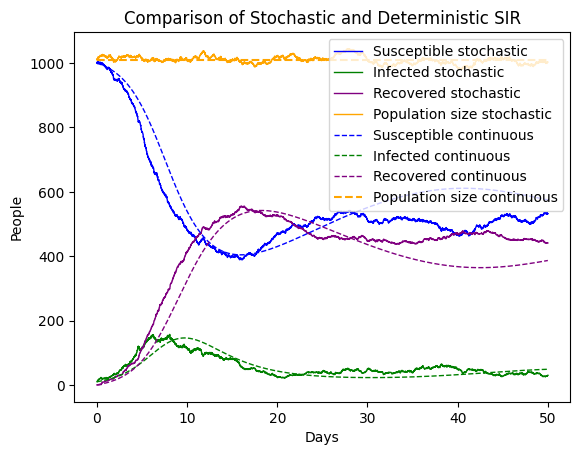

In [749]:
np.random.seed(2)

# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 50

# Run stochastic SIR simulation
infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.run()

# Make ax and generate plot
fig, ax = plt.subplots(1)
infection.plot(ax, label=True)

# Set tmax to highest t in stochastic model
tmax = infection.t[-1]
dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.title("Comparison of Stochastic and Deterministic SIR")
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.savefig("StochasticVsDeterministic")
plt.show()

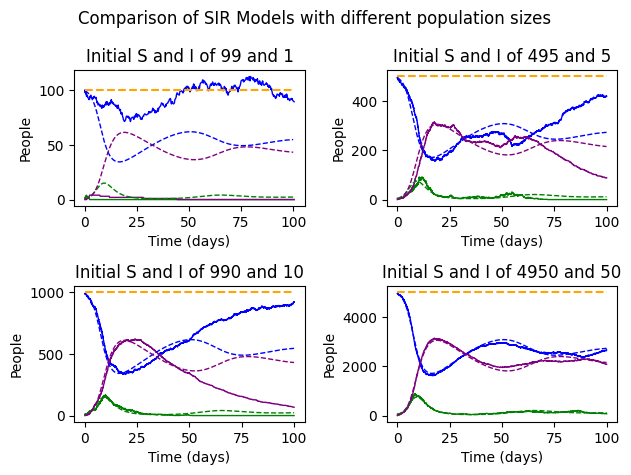

In [725]:
np.random.seed(1)

# Define the different initial values to compare
initial_SIR= [500, 1, 0]
initial_SIR_values= [
    [99, 1, 0],
    [495, 5, 0],
    [990, 10, 0],
    [4950, 50, 0]
]

mu = 0.03
tmax = 100

beta = 1
gamma = 0.5

for i in range(len(initial_SIR_values)):
    initial_SIR = initial_SIR_values[i]

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()
    
    plt.subplot(2, 2, i+1)
    plt.title(f"Initial S and I of {initial_SIR[0]} and {initial_SIR[1]}")
    plt.xlabel('Time (days)')
    plt.ylabel('People')
    infection.plot(plt.gca(), N=False, label=True)
    continuous_infection.plot(plt.gca())

# Compare outcomes of different runs
plt.suptitle("Comparison of SIR Models with different population sizes")
plt.tight_layout()
plt.show()

In [726]:
class Analyze:
    def __init__(self, N, tmax, initial_SIR, beta, gamma, dt = 0.001, mu = 0):
        self.N = N
        self.N_timesteps = int(tmax / dt)
        self.t = [i * dt for i in range(self.N_timesteps - 1)]
        self.results = {'S': {i: [0 for j in range(N)] for i in self.t},
                        'I': {i: [0 for j in range(N)] for i in self.t},
                        'R': {i: [0 for j in range(N)] for i in self.t}}
        
        self.average = []
        self.std = []
        self.initial_SIR = initial_SIR
        self.gamma = gamma
        self.beta = beta
        self.tmax = tmax
        self.mu = mu

    def convert_regular_timesteps(self):
        """
        Convert stochastic SIR simulation results with irregular timesteps to regular timesteps.

        This function performs N runs of a stochastic SIR simulation and converts the resulting
        irregularly sampled data to a set of regular timesteps. It extracts the dynamics of
        susceptible (S), infected (I), and recovered (R) individuals and stores them in the
        'results' attribute of the calling object.
        """ 

        # Perform N runs
        for run in range(self.N):

            # Run stochastic SIR simulation
            infection = StochasticSIR(self.initial_SIR, self.beta, self.gamma, self.tmax, self.mu)
            infection.run()

            # Extract dynamics
            stocastic_SIR = infection.SIR
            stochastic_t = infection.t
            
            self.results['S'][0][run] = stocastic_SIR['S'][0]
            self.results['I'][0][run] = stocastic_SIR['I'][0]
            self.results['R'][0][run] = stocastic_SIR['R'][0]

            # Set initial values for stochastic timestep
            t_index = 1
            next_stochastic_t = stochastic_t[t_index]

            previous_t = self.t[0]
            
            # For each timestep
            for current_t in self.t:

                # If current timestep is before the next timestep of the stochastic SIR simulation
                if current_t < next_stochastic_t:

                    self.results['S'][current_t][run] = self.results['S'][previous_t][run]
                    self.results['I'][current_t][run] = self.results['I'][previous_t][run]
                    self.results['R'][current_t][run] = self.results['R'][previous_t][run]

                # If current timestep is after the next timestep of the stochastic SIR simulation
                else:

                    self.results['S'][current_t][run] = stocastic_SIR['S'][t_index]
                    self.results['I'][current_t][run] = stocastic_SIR['I'][t_index]
                    self.results['R'][current_t][run] = stocastic_SIR['R'][t_index]

                    # Increase stochastic time index and next timestep
                    t_index += 1
                    next_stochastic_t = stochastic_t[t_index]

                    previous_t = current_t
                    
    def get_average(self):
        return {'S': np.array([np.mean(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.mean(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.mean(self.results['R'][i]) for i in self.t])}
    
    def get_std(self):
        return {'S': np.array([np.std(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.std(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.std(self.results['R'][i]) for i in self.t])}
    
    def get_covariance(self):
        # Calculate the corvariance between S and I
        if len(self.average) == 0:
            self.average = self.get_average()

        covariance = []
        for index, i in enumerate(self.t):
            covariance.append(np.sum([(self.results['S'][i][j] - self.average['S'][index]) * (self.results['I'][i][j] - self.average['I'][index]) for j in range(self.N)]) / (self.N - 1))
        
        return covariance


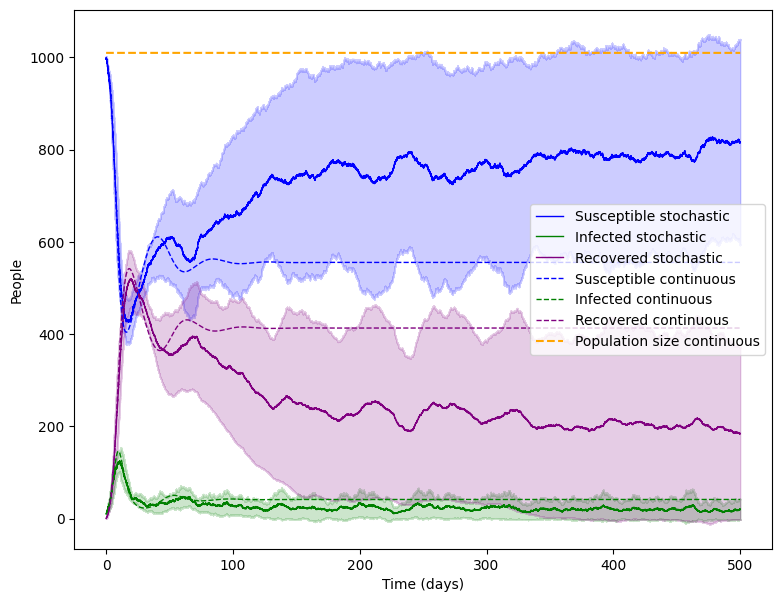

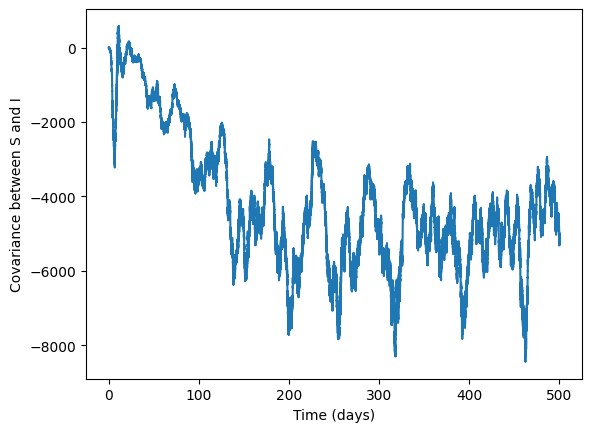

In [727]:
np.random.seed(0)

# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('People')
plt.savefig("StochasticAvgVsDeterministic")
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

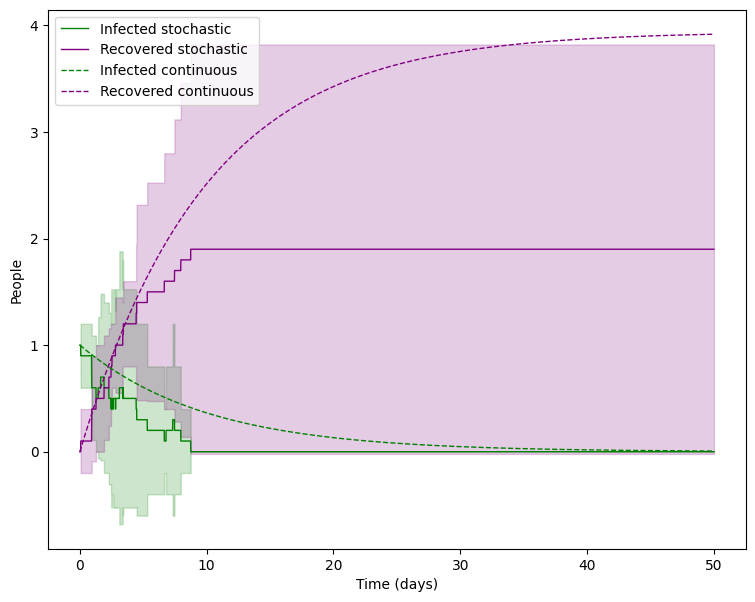

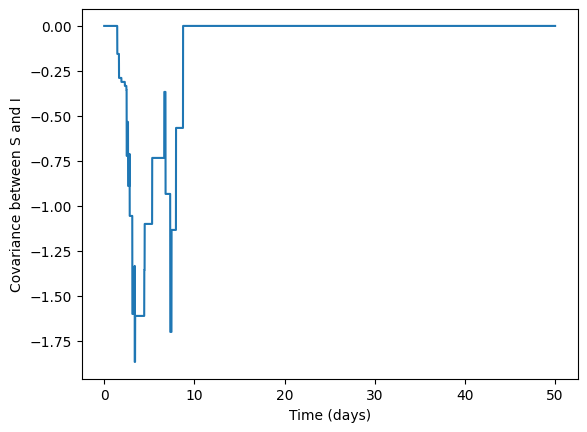

In [728]:
# Initial values SIR model
initial_SIR = [500, 1, 0]
beta = 0.3
gamma = 0.4
tmax = 50
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True, S=False)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma)
continuous_infection.run()
continuous_infection.plot(ax, S=False, N=False)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

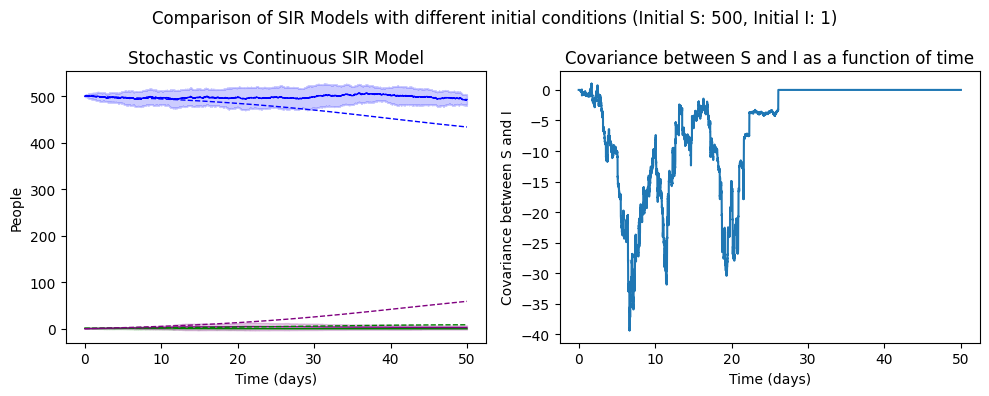

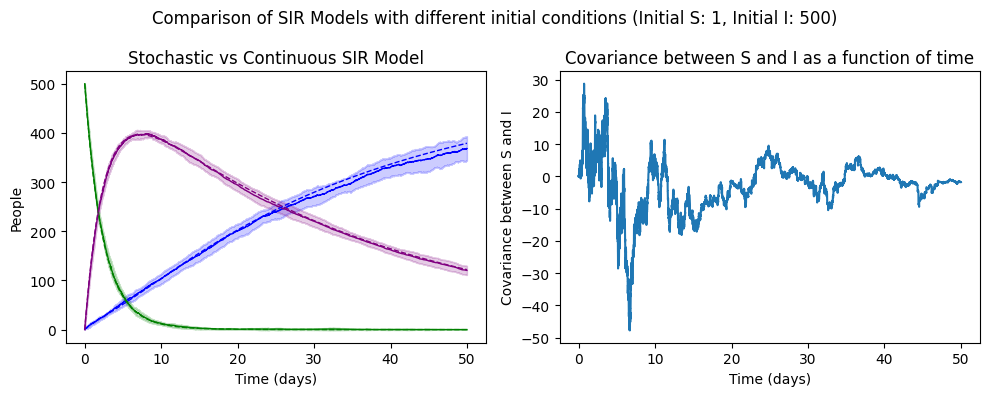

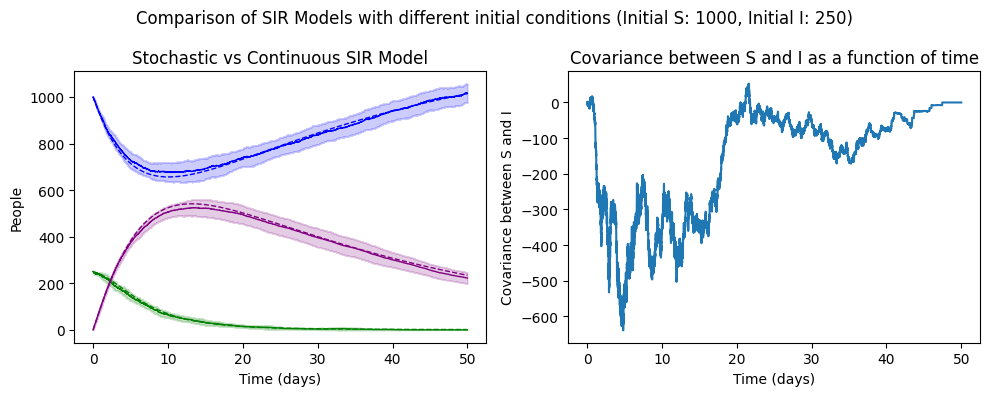

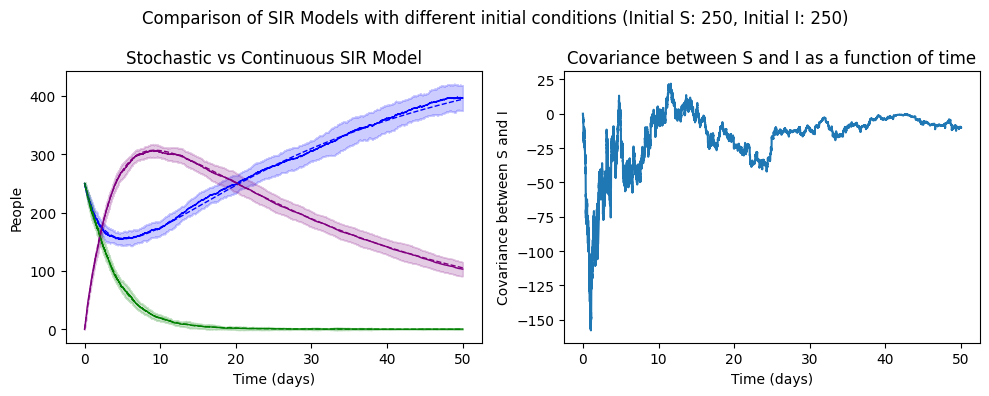

In [760]:
#TODO: covariance, legend position

# Define the initial values
initial_SIR_values = [
    [500, 1, 0],
    [1, 500, 0],
    [1000, 250, 0],
    [250, 250, 0]
]
beta = 0.5
gamma = 0.4
mu = 0.03
tmax = 50
N_runs = 10

# Iterate through initial conditions and create separate figures
for i in range(len(initial_SIR_values)):
    initial_SIR = initial_SIR_values[i]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Comparison of SIR Models with different initial conditions (Initial S: {initial_SIR[0]}, Initial I: {initial_SIR[1]})")

    # Plot your data on the left subplot
    axes[0].set_title(f"Stochastic vs Continuous SIR Model")
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('People')
    infection.plot(axes[0], std=std, N=False, label=True)
    continuous_infection.plot(axes[0],  N=False)

    
    axes[1].plot(t, covariance)   
    axes[1].set_title(f"Covariance between S and I as a function of time")
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Covariance between S and I')

    fig.tight_layout()
    plt.show()


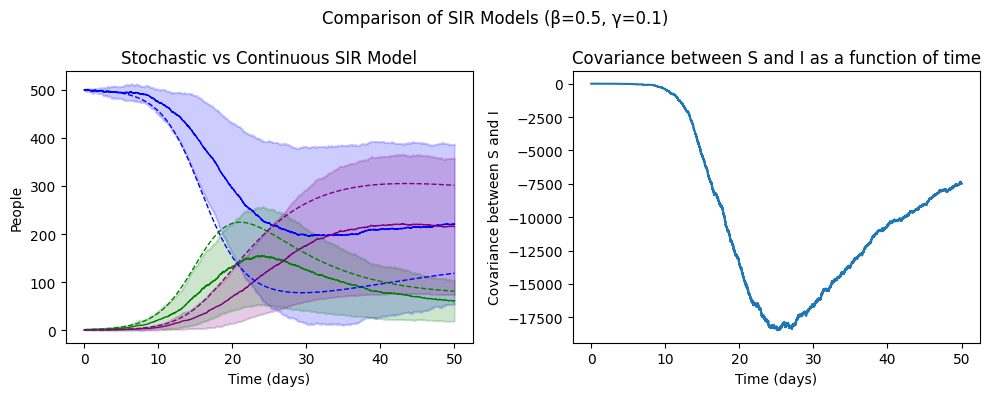

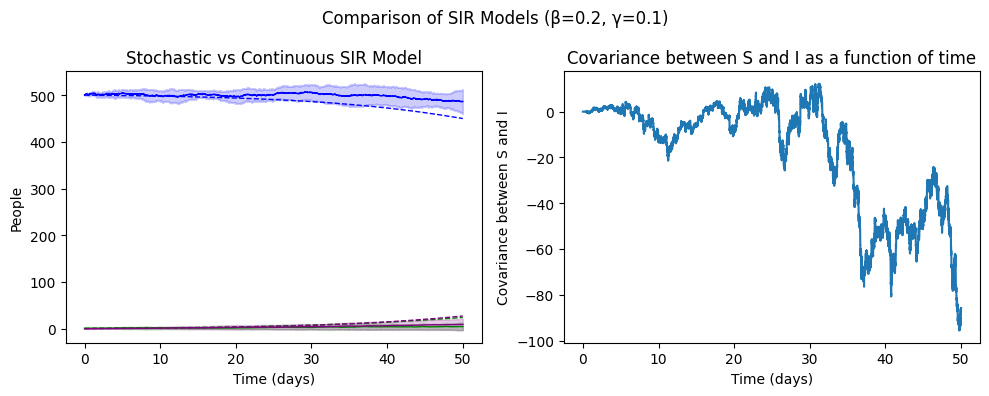

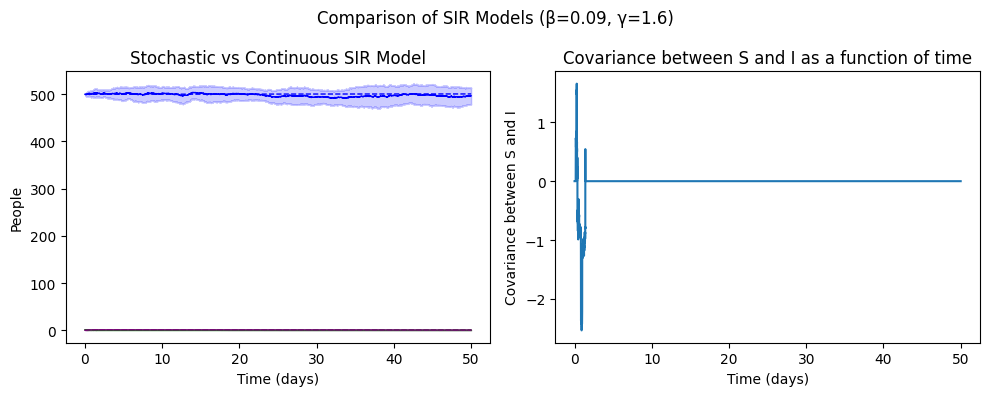

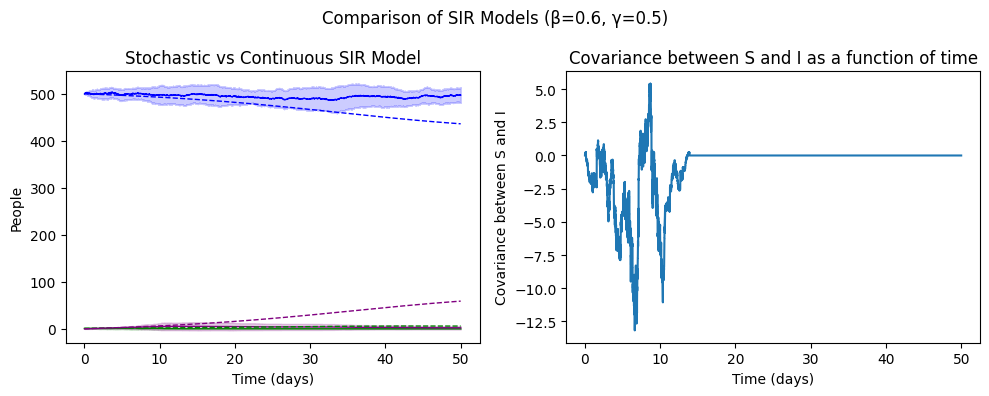

In [762]:
#TODO: covariance

# Define the different initial values to compare
initial_SIR = [500, 1, 0]
beta_gamma = [
    [0.5, 0.1],
    [0.2, 0.1],
    [0.09, 1.6],
    [0.6, 0.5]
]
mu = 0.03
tmax = 50
N_runs = 10

# Iterate through different beta and gamma values
for i in range(len(beta_gamma)):
    beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()

    # Create a new figure for each set of beta and gamma values
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Comparison of SIR Models (β={beta}, γ={gamma})")


    # Plot your data on the left subplot
    axes[0].set_title(f"Stochastic vs Continuous SIR Model")
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('People')
    infection.plot(axes[0], std=std, N=False, label=True)
    continuous_infection.plot(axes[0],  N=False)

    axes[1].plot(t, covariance)   
    axes[1].set_title(f"Covariance between S and I as a function of time")
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Covariance between S and I')

    fig.tight_layout()
    plt.show()

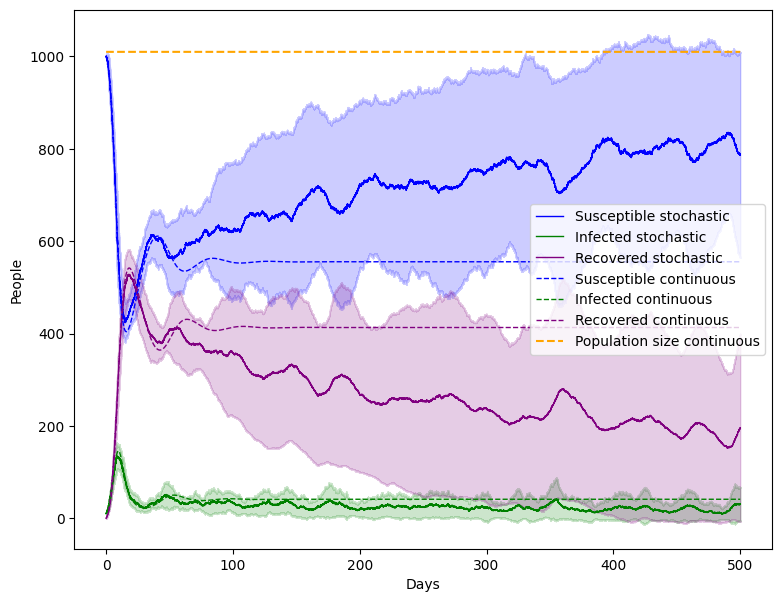

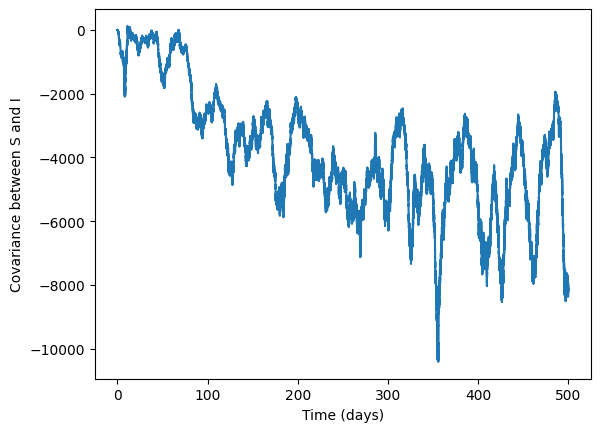

In [731]:
# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

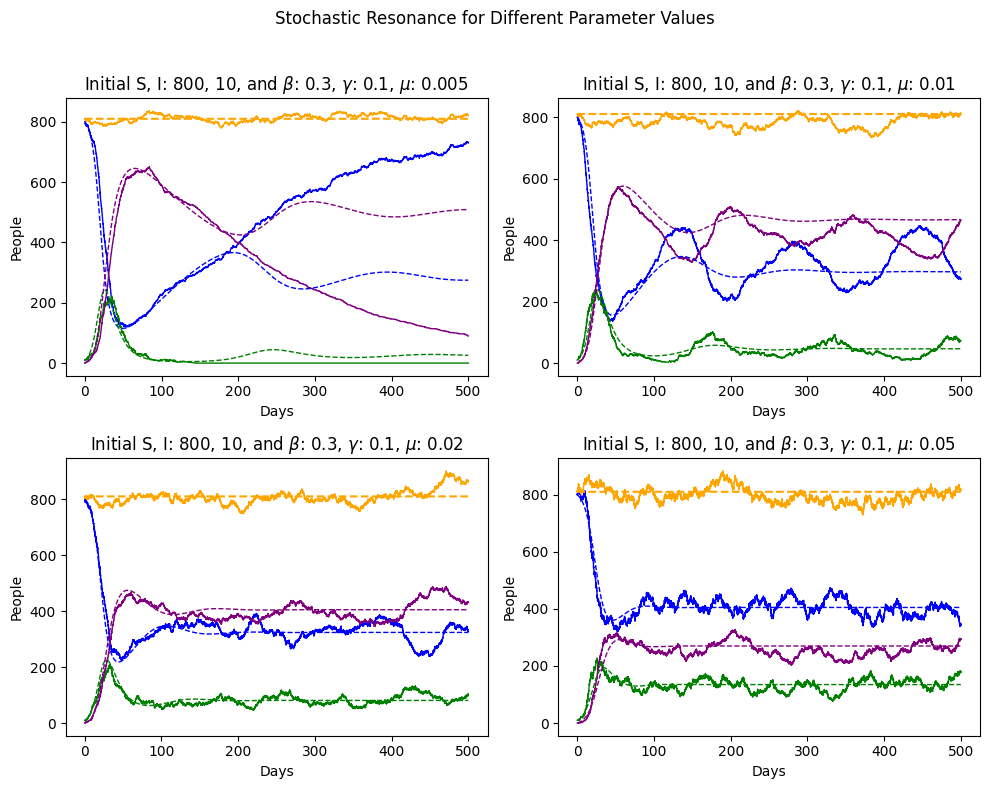

In [791]:
seeds = [1, 0, 0, 3]

# Define the different parameter combinations to investigate
parameters = [
    [[800, 10, 0], 0.3, 0.1, 0.005],  # Parameter Set 1
    [[800, 10, 0], 0.3, 0.1, 0.01],  # Parameter Set 2
    [[800, 10, 0], 0.3, 0.1, 0.02],  # Parameter Set 3
    [[800, 10, 0], 0.3, 0.1, 0.05]  # Parameter Set 4
]
tmax = 500
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Stochastic Resonance for Different Parameter Values")

# Iterate through parameter combinations and create subplots
for i, (initial_SIR, beta, gamma, mu) in enumerate(parameters):
    np.random.seed(seeds[i])
    row = i // 2
    col = i % 2

    # Create an individual subplot for each parameter combination
    ax = axs[row, col]

    # Run stochastic SIR simulation
    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()

    # Set tmax to the highest t in the stochastic model
    tmax = infection.t[-1]
    dt = 0.1

    # Run continuous SIR simulation
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
    continuous_infection.run()

    # Generate the plot in the current subplot
    infection.plot(ax, label="Stochastic SIR")
    continuous_infection.plot(ax)

    # Set title, labels, and legend for the subplot
    ax.set_title(fr"Initial S, I: {initial_SIR[0]}, {initial_SIR[1]}, and $\beta$: {beta}, $\gamma$: {gamma}, $\mu$: {mu}")
    ax.set_xlabel('Days')
    ax.set_ylabel('People')

# Adjust the layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or display the figure
plt.savefig("Stochastic_Resonance.png")
plt.show()

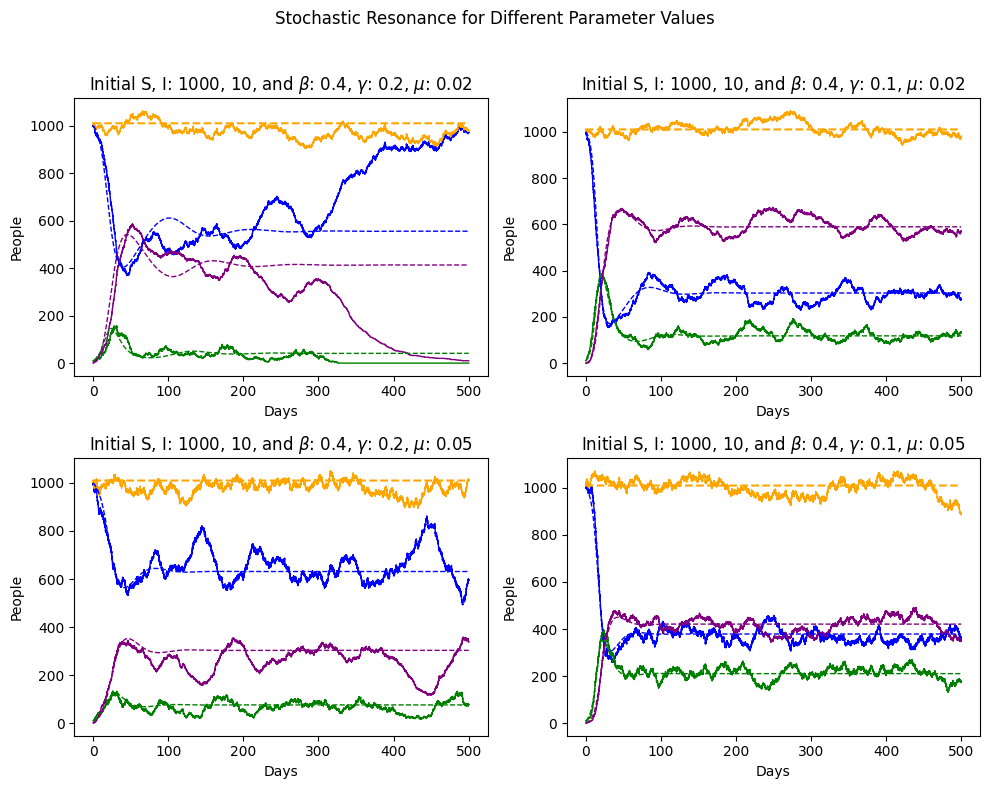

In [817]:
seeds = [1, 6, 1, 3]

# Define the different parameter combinations to investigate
parameters = [
    [0.4, 0.2, 0.02],
    [0.4, 0.1, 0.02],
    [0.4, 0.2, 0.05],
    [0.4, 0.1, 0.05]
]
initial_SIR = [1000, 10, 0]
tmax = 500
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Stochastic Resonance for Different Parameter Values")

# Iterate through parameter combinations and create subplots
for i, (beta, gamma, mu) in enumerate(parameters):
    np.random.seed(seeds[i])
    row = i // 2
    col = i % 2

    # Create an individual subplot for each parameter combination
    ax = axs[row, col]

    # Run stochastic SIR simulation
    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()

    # Set tmax to the highest t in the stochastic model
    tmax = infection.t[-1]
    dt = 0.1

    # Run continuous SIR simulation
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
    continuous_infection.run()

    # Generate the plot in the current subplot
    infection.plot(ax, label="Stochastic SIR")
    continuous_infection.plot(ax)

    # Set title, labels, and legend for the subplot
    ax.set_title(fr"Initial S, I: {initial_SIR[0]}, {initial_SIR[1]}, and $\beta$: {beta}, $\gamma$: {gamma}, $\mu$: {mu}")
    ax.set_xlabel('Days')
    ax.set_ylabel('People')

# Adjust the layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or display the figure
plt.savefig("Stochastic_Transients.png")
plt.show()

In [818]:
class InvestigateExtinction:
    def __init__(self, N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax):
        self.N_min = N_min
        self.N_max = N_max
        self.R_min = R_min
        self.R_max = R_max
        self.N_runs = N_runs
        self.resolution = resolution
        self.varying_parameter = varying_parameter
        self.smoothing_resolution = smoothing_resolution
        self.tmax = tmax


    def get_extinction_duration(self, N, R):
        # Initial values SIR model
        initial_SIR = [int(N  * 0.95), int(N * 0.05), 0]
        if self.varying_parameter == 'gamma':
            beta = 1
            mu = 0.05
            gamma = (beta / R) - mu
        elif self.varying_parameter == 'beta':
            gamma = 1
            mu = 0.05
            beta = R * (gamma + mu)

        extinction_t = 0
        for run in range(self.N_runs):
            infection = StochasticSIR(initial_SIR, beta, gamma, self.tmax, mu=mu)
            infection.run()
            t = infection.t
            extinction_t +=  next((i for index, i in enumerate(t) if infection.SIR['I'][index] == 0), self.tmax) / self.N_runs
        return extinction_t
    
    def get_extinction_data(self):
        # Create a coarser grid for N and R values
        N_values = np.linspace(self.N_min, self.N_max, self.resolution)
        R_values = np.linspace(self.R_min, self.R_max, self.resolution)

        extinction_data = []
        for R in R_values:
            Ns = []
            for N in N_values:
                Ns.append(self.get_extinction_duration(N, R))
            extinction_data.append(Ns)
            
        return extinction_data, N_values, R_values
    
    def smooth_data(self, N_values, R_values, extinction_data):
        # Create an interpolation function using the coarser grid and p values
        interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')

        # Define a higher-resolution grid
        N_values_fine = np.linspace(self.N_min, self.N_max, self.smoothing_resolution)
        R_values_fine = np.linspace(self.R_min, self.R_max, self.smoothing_resolution)

        # Interpolate p values to the fine grid
        return interp_func(N_values_fine, R_values_fine)


    def investigate_extinction(self):
        extinction_data, N_values, R_values = self.get_extinction_data()

        extinction_data = self.smooth_data(N_values, R_values, extinction_data)

        return extinction_data


    def plot_extinction(self, extinction_data):

        # Create the imshow plot using the high-resolution p values
        plt.imshow(extinction_data, origin='lower',  extent=[self.N_min, self.N_max, self.R_min, self.R_max], aspect='auto', norm=LogNorm(0.1, 500))

        colorbar = plt.colorbar(label=f'Average stochastic extinction time over {self.N_runs} runs')
        colorbar.set_ticks([0.1, 1, 10, 100, 500])
        colorbar.set_ticklabels(['0.1', '1', '10', '100', 'No extinction'])

        plt.xlabel('N')
        plt.ylabel(r'R$_0$')
        plt.xticks([20, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
        plt.yticks([0.1, 0.5, 1, 1.5, 2, 2.5, 3])
        plt.title(fr'Average stochastic extinction time for various values for N and $\{self.varying_parameter}$')
        plt.tight_layout()
        plt.show()

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\4059114126.py:50: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\4059114126.py:57: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids,

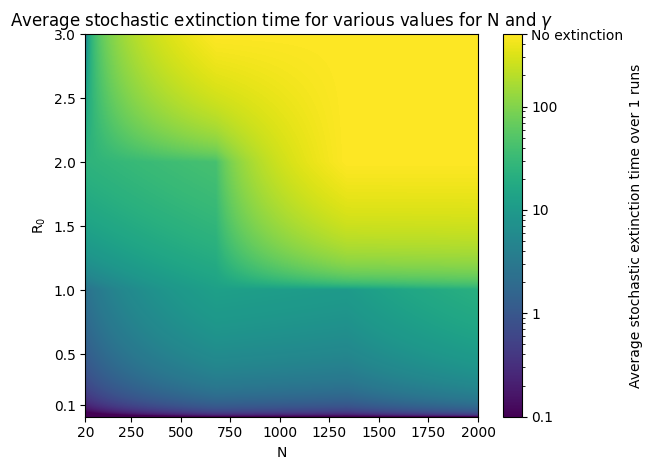

In [819]:
# Define the range for N and R
N_min, N_max = 20, 2000
R_min, R_max = 0.01, 3
N_runs = 1
resolution = 4
varying_parameter = 'gamma'
smoothing_resolution = 1000
investigation = InvestigateExtinction(N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax)
extinction_data = investigation.investigate_extinction()
investigation.plot_extinction(extinction_data)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\4059114126.py:50: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\4059114126.py:57: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids,

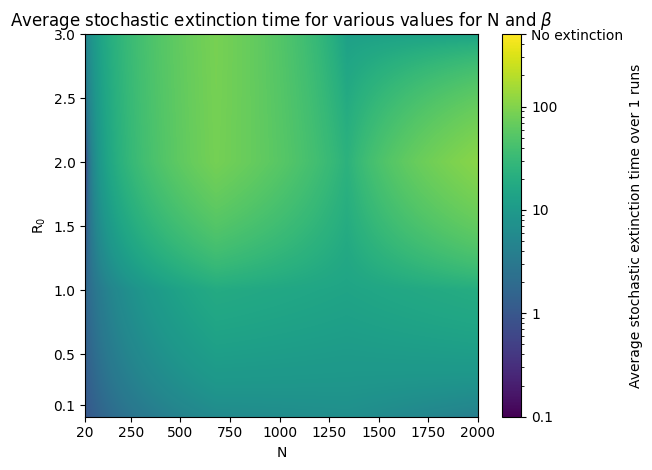

In [820]:
# Define the range for N and R
N_min, N_max = 20, 2000
R_min, R_max = 0.01, 3
N_runs = 1
resolution = 4
varying_parameter = 'beta'
smoothing_resolution = 1000
investigation = InvestigateExtinction(N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax)
extinction_data = investigation.investigate_extinction()
investigation.plot_extinction(extinction_data)

In [990]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import pandas as pd

In [991]:
def get_graph_statistics(graph, plot_degree_distribution = True):
    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    all_degrees = list(dict(graph.degree()).values())
    N_edges = graph.number_of_edges()
    try:
        diameter = nx.diameter(graph)
    except:
        diameter = np.inf


    # Calculate path lengths
    all_pairs_paths = dict(nx.all_pairs_shortest_path_length(graph))
    all_path_lengths = [length for source_paths in all_pairs_paths.values() for length in source_paths.values()]


    # Create dictionaries for each centrality measure
    degree_centrality = {
        "min": min(degree_centrality.values()),
        "max": max(degree_centrality.values()),
        "avg": sum(degree_centrality.values()) / len(degree_centrality)
    }

    degree = {
        "min": min(all_degrees),
        "max": max(all_degrees),
        "avg": sum(all_degrees) / len(all_degrees)
    }

    betweenness = {
        "min": min(betweenness_centrality.values()),
        "max": max(betweenness_centrality.values()),
        "avg": sum(betweenness_centrality.values()) / len(betweenness_centrality)
    }

    closeness = {
        "min": min(closeness_centrality.values()),
        "max": max(closeness_centrality.values()),
        "avg": sum(closeness_centrality.values()) / len(closeness_centrality)
    }


   # Calculate average and longest path length
    avg_path_length = sum(all_path_lengths) / len(all_path_lengths)
    longest_path_length = max(all_path_lengths)

    # If the plot_degree_distribution option is True, create a degree distribution bar plot
    if plot_degree_distribution:
        #degree_values = list(degree_centrality.values())
        plt.hist(all_degrees, bins=20, alpha=0.5)
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.show()

    # Return all statistics as a dictionary of dictionaries
    return {
        "degree": degree,
        "degree centrality": degree_centrality,
        "betweenness": betweenness,
        "closeness": closeness,
        "average path length": avg_path_length,
        "longest path length": longest_path_length,
        "diameter": diameter,
        "number of edges": N_edges
    }

In [992]:
def read_data(filename):
    df = pd.read_csv(filename, delimiter = ';', index_col=0)

    # Create the network from given external transmission network
    graph = nx.Graph()
    for node1 in df.index:
        graph.add_node(node1)
        for node2 in df.columns:
            transmission = df.loc[node1, node2]

            if transmission > 0 and not graph.has_edge(node1, node2):
                node2_int = int(node2)
                graph.add_edge(node1, node2_int, transmission_rate=transmission)
    
    return graph

In [993]:
def plot_graph(graph, infected_nodes = []):

    node_colors = ['orange' if node in infected_nodes else 'purple' for node in graph.nodes()]

    options = {"node_size": 5, "node_color": node_colors, "width": 0.3}
    nx.draw(graph, **options)
    plt.show()

In [994]:
def infect_network(graph, beta, gamma, N_iterations, I_initial = 5, infected_nodes = None):
    # Set model parameters
    model = ep.SIRModel(graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) 
    cfg.add_model_parameter('gamma', gamma)

    if infected_nodes is None:
        cfg.add_model_parameter("initial_infected_nodes", I_initial)
    else:
        cfg.add_model_parameter("initial_infected_nodes", infected_nodes)

    model.set_initial_status(cfg)

    #Perform simulation 
    iterations = model.iteration_bunch(N_iterations, node_status=False)

    return model, iterations

In [995]:
# Define a function to print statistics in a nice way
def print_statistics(title, stats):
    print(f"Statistics for {title}:")
    try:
        print(f"  Minimum: {stats['min']}")
        print(f"  Maximum: {stats['max']}")
        print(f"  Average: {stats['avg']}")
    except TypeError:
        print(stats)

In [996]:
def plot(model, iterations, ax):
    times = [iteration['iteration'] for iteration in iterations]
    S = [iteration['node_count'][0] for iteration in iterations]
    I = [iteration['node_count'][1] for iteration in iterations]
    R = [iteration['node_count'][2] for iteration in iterations]

    plt.figure(figsize=(10, 6))
    ax.plot(times, S, label='Susceptible')
    ax.plot(times, I, label='Infected')
    ax.plot(times, R, label='Recovered')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number of Nodes')
    ax.plot()


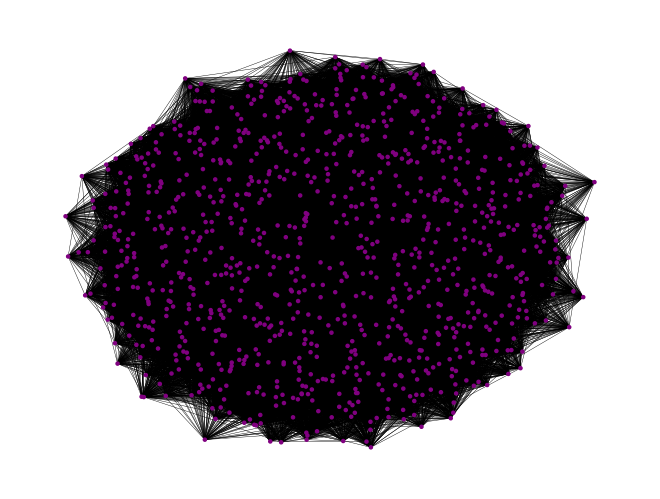

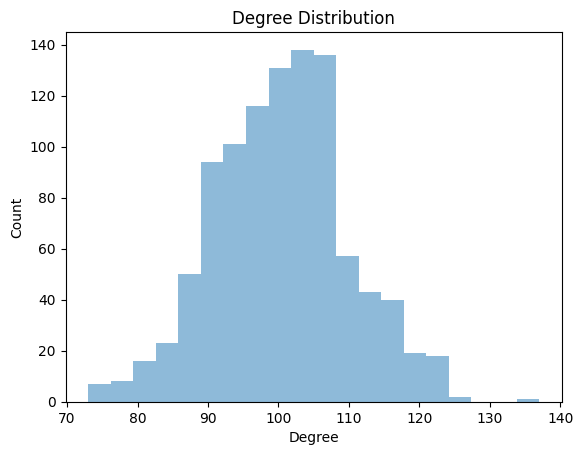

Statistics for degree:
  Minimum: 73
  Maximum: 137
  Average: 100.378
Statistics for degree centrality:
  Minimum: 0.07307307307307308
  Maximum: 0.13713713713713713
  Average: 0.10047847847847863
Statistics for betweenness:
  Minimum: 0.00045822711623832687
  Maximum: 0.001719707047056543
  Average: 0.0009013562660857245
Statistics for closeness:
  Minimum: 0.518961038961039
  Maximum: 0.5368081676518001
  Average: 0.5264526783013342
Statistics for average path length:
1.897654
Statistics for longest path length:
3
Statistics for diameter:
3
Statistics for number of edges:
50189


In [997]:
#Generating a network
nodes = 1000
probability = 0.1
graph = nx.erdos_renyi_graph(nodes, probability)
plot_graph(graph)

statistics = get_graph_statistics(graph)

# Print statistics for each centrality measure
for centrality, stats in statistics.items():
    print_statistics(centrality, stats)


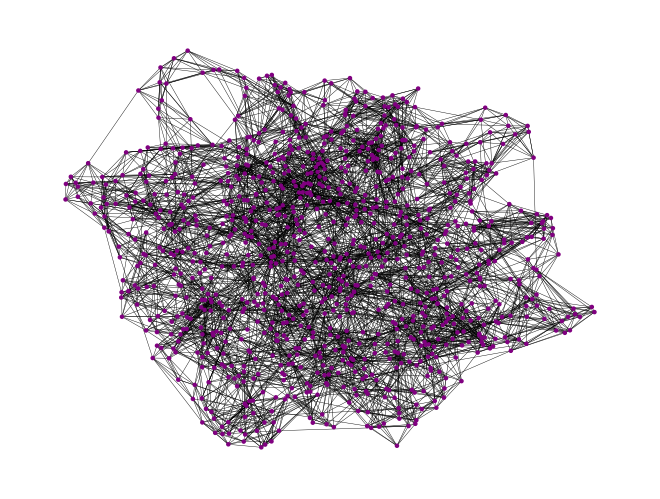

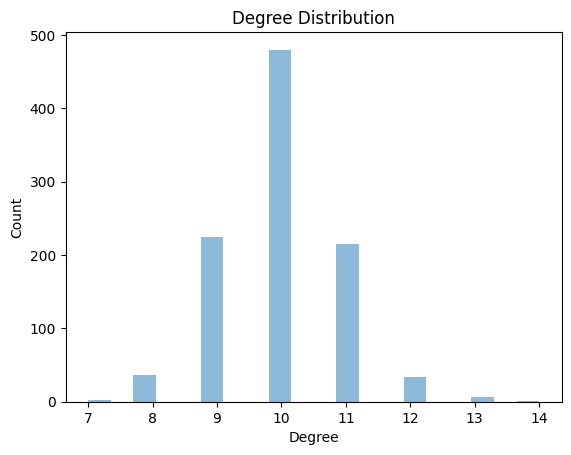

Statistics for degree:
  Minimum: 7
  Maximum: 14
  Average: 10.0
Statistics for degree centrality:
  Minimum: 0.007007007007007007
  Maximum: 0.014014014014014014
  Average: 0.010010010010010006
Statistics for betweenness:
  Minimum: 0.00022968706651714776
  Maximum: 0.01553590788858642
  Average: 0.003501674018708086
Statistics for closeness:
  Minimum: 0.1940182559720334
  Maximum: 0.25387547649301145
  Average: 0.2230118631507797
Statistics for average path length:
4.490176
Statistics for longest path length:
7
Statistics for diameter:
7
Statistics for number of edges:
5000


In [998]:
nodes = 1000
k = 10 
p = 0.1
graph = nx.watts_strogatz_graph(nodes, k, p)
plot_graph(graph)

statistics = get_graph_statistics(graph)

# Print statistics for each centrality measure
for centrality, stats in statistics.items():
    print_statistics(centrality, stats)


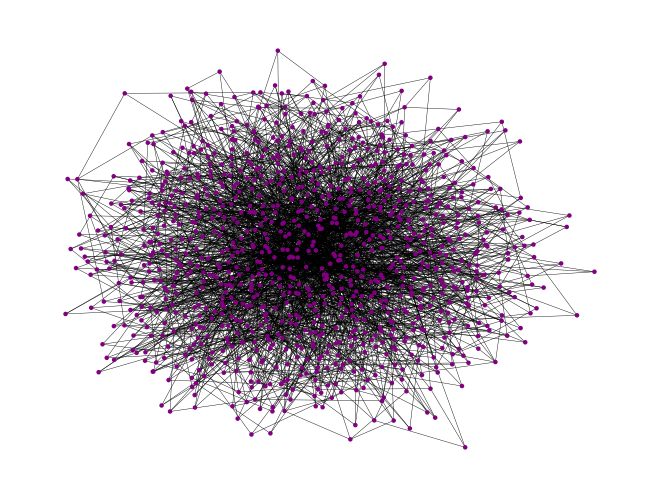

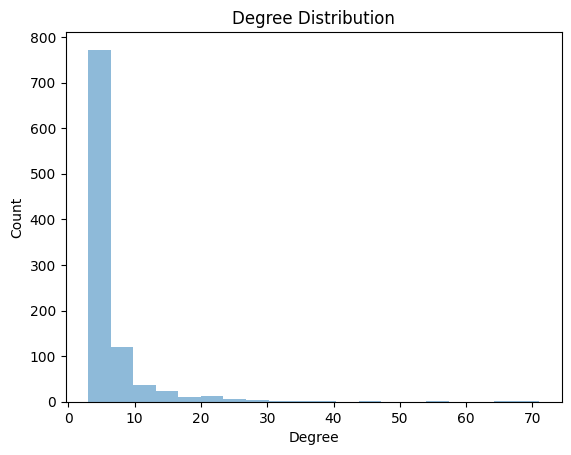

Statistics for degree:
  Minimum: 3
  Maximum: 71
  Average: 5.982
Statistics for degree centrality:
  Minimum: 0.003003003003003003
  Maximum: 0.07107107107107107
  Average: 0.005987987987987958
Statistics for betweenness:
  Minimum: 4.8715435372726725e-05
  Maximum: 0.10990742635892607
  Average: 0.0025499888666221326
Statistics for closeness:
  Minimum: 0.2266333938294011
  Maximum: 0.4143508917461634
  Average: 0.2843841626130749
Statistics for average path length:
3.541344
Statistics for longest path length:
6
Statistics for diameter:
6
Statistics for number of edges:
2991


In [999]:
nodes = 1000
m = 3
graph = nx.barabasi_albert_graph(nodes, m)
plot_graph(graph)

statistics = get_graph_statistics(graph)

# Print statistics for each centrality measure
for centrality, stats in statistics.items():
    print_statistics(centrality, stats)

In [1028]:
def calculate_similarity_score(er_properties, other_properties, statistics_to_compare):
    similarity_score = 0

    for stat in statistics_to_compare:
        if isinstance(er_properties[stat], dict):
            er_stat = er_properties[stat]
            other_stat = other_properties[stat]
            for key in er_stat.keys():
                similarity_score += abs(er_stat[key] - other_stat[key])
        else:
            similarity_score += abs(er_properties[stat] - other_properties[stat])

    return similarity_score

def find_best_parameters(statistics_to_compare, n, p_er):
    er_network = nx.erdos_renyi_graph(n, p_er)
    er_properties = get_graph_statistics(er_network, plot_degree_distribution=False)

    best_m = 0
    best_similarity_score = np.inf

    for m in range(1, 50):
        ba_network = nx.barabasi_albert_graph(n, m)
        ba_properties = get_graph_statistics(ba_network, plot_degree_distribution=False)
        similarity_score = calculate_similarity_score(er_properties, ba_properties, statistics_to_compare)

        if similarity_score < best_similarity_score:
            best_similarity_score = similarity_score
            best_m = m

    best_k = 0
    best_p = 0
    best_similarity_score = np.inf

    for k in range(2, 11):
        for p in np.arange(0.01, 0.21, 0.01):
            ws_network = nx.watts_strogatz_graph(n, k, p)
            ws_properties = get_graph_statistics(ws_network, plot_degree_distribution=False)

            similarity_score = calculate_similarity_score(er_properties, ws_properties, statistics_to_compare)

            if similarity_score < best_similarity_score:
                best_similarity_score = similarity_score
                best_k = k
                best_p = p

    return best_m, best_k, round(best_p, 3)


In [1033]:
def compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k):
    N_iterations = 200
    fig, axes = plt.subplots(2, 2)

    er_graph = nx.erdos_renyi_graph(nodes, p_er)

    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(er_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(model, iterations, ax)
        ax.set_title(f"β = {beta}, γ = {gamma} ")

    fig.suptitle(f"Dynamics infection spread on Erdos Renyi network with {nodes} nodes, p={p_er}")
    fig.tight_layout()
    plt.show()


    fig, axes = plt.subplots(2, 2)
    ws_graph = nx.watts_strogatz_graph(nodes, best_k, best_p)
    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(ws_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(model, iterations, ax)
        ax.set_title(f"β = {beta}, γ = {gamma} ")
    fig.suptitle(f"Dynamics infection spread on Watt Strogatz network with {nodes} nodes, k={best_k}, p={best_p}")
    fig.tight_layout()
    plt.show()


    fig, axes = plt.subplots(2, 2)
    ba_graph = nx.barabasi_albert_graph(nodes, best_m)
    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(ba_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(model, iterations, ax)
        ax.set_title(f"β = {beta}, γ = {gamma} ")
    fig.suptitle(f"Dynamics infection spread on Barabasi Albert network with {nodes} nodes, m={best_m}")
    fig.tight_layout()
    plt.show()

    return er_graph, ws_graph, ba_graph

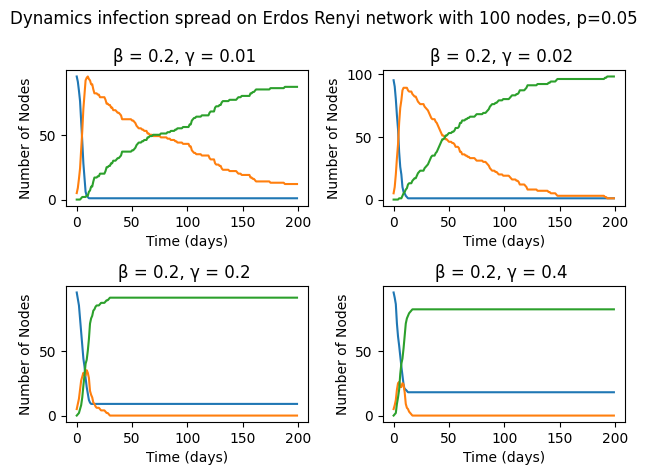

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

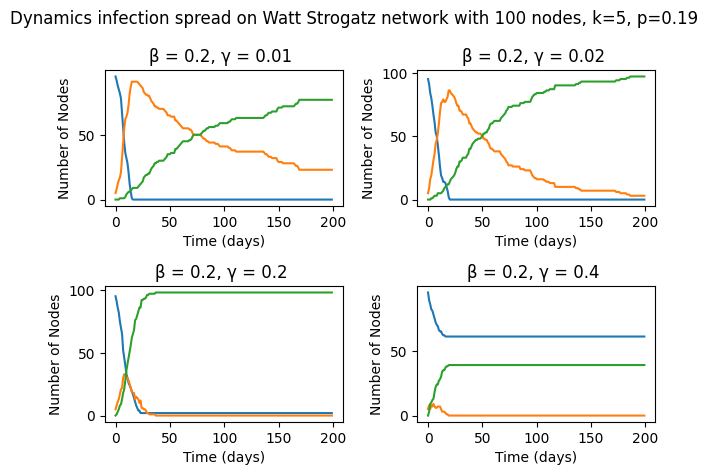

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

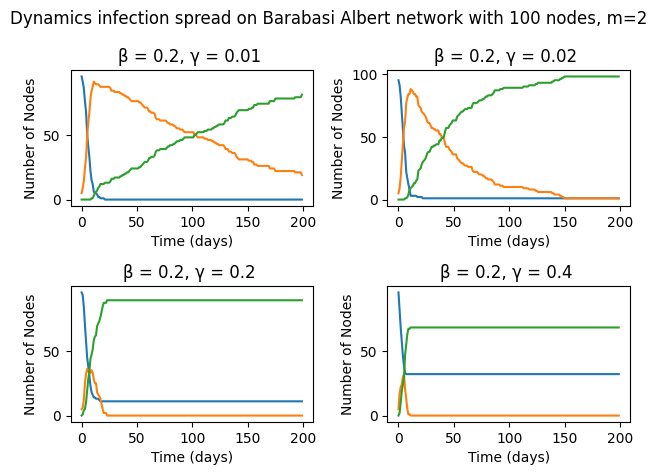

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1035]:
networks = {}

# Define the statistics to compare
statistics_to_compare = ["degree centrality", "betweenness", "closeness", "average path length", "longest path length", "number of edges"]

# Parameters
nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

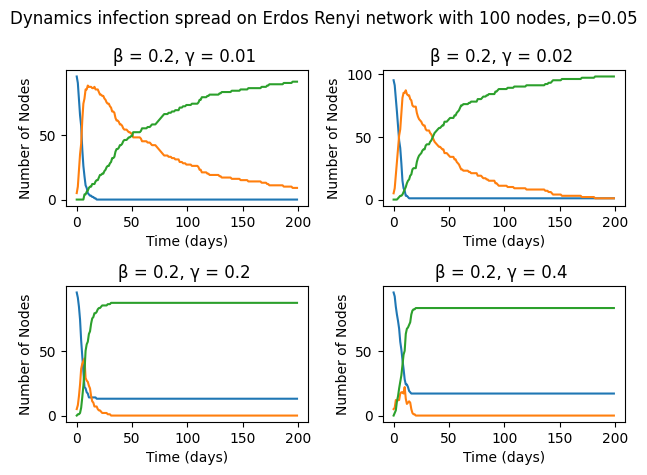

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

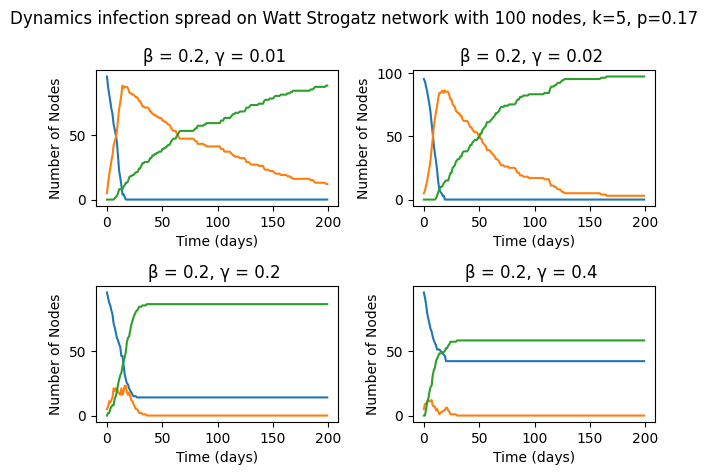

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

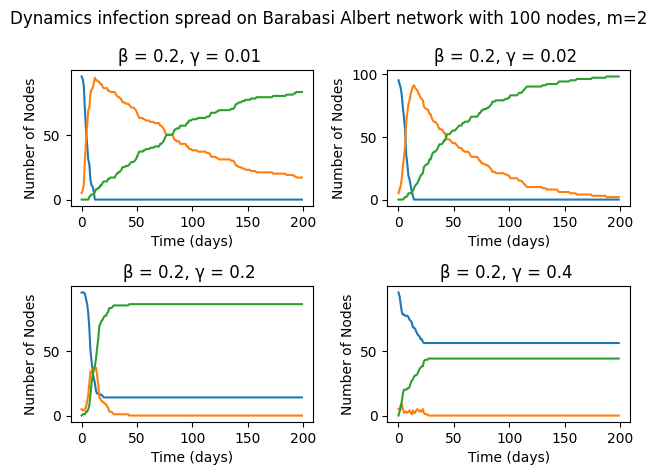

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1036]:
# Define the statistics to compare
statistics_to_compare = ["average path length", "longest path length", "number of edges"]

# Parameters
nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

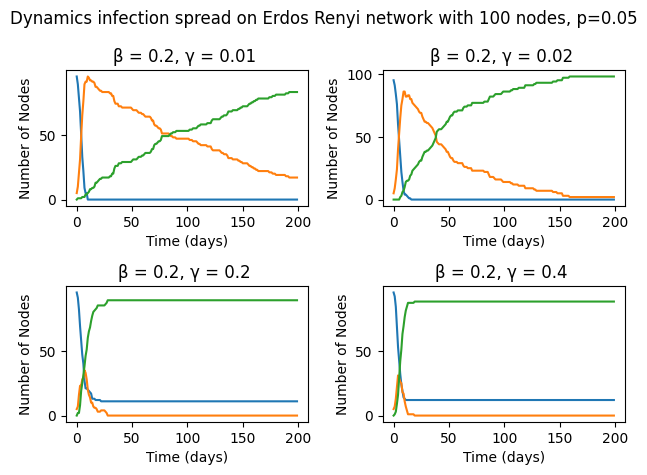

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

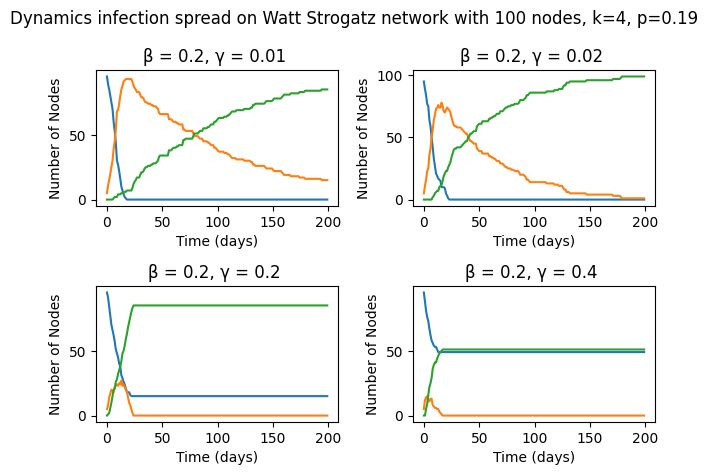

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

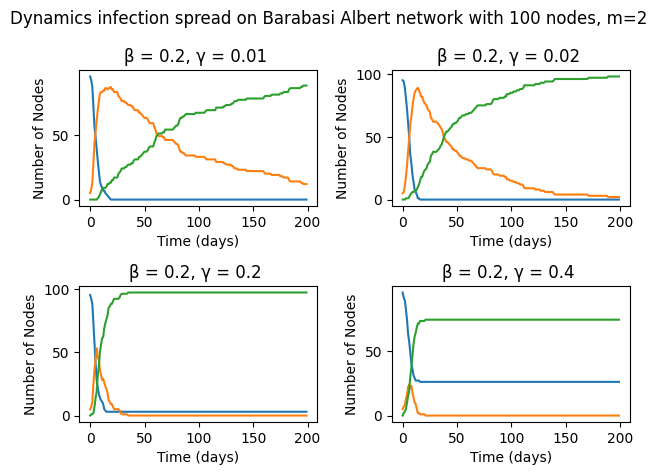

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1037]:
# Define the statistics to compare
statistics_to_compare = ["degree centrality", "average path length", "number of edges"]

# Parameters
nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

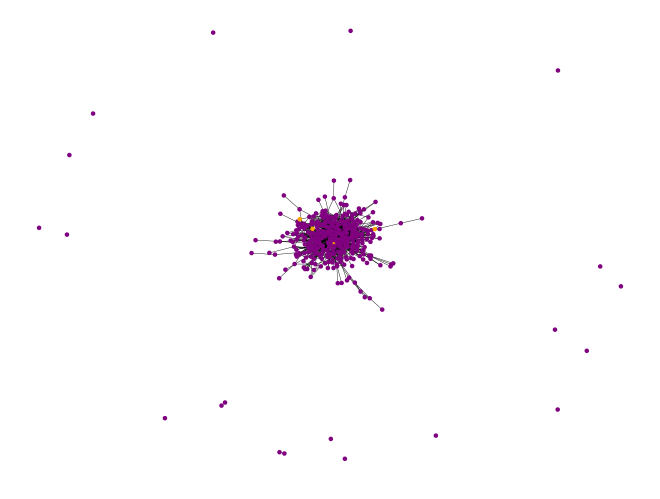

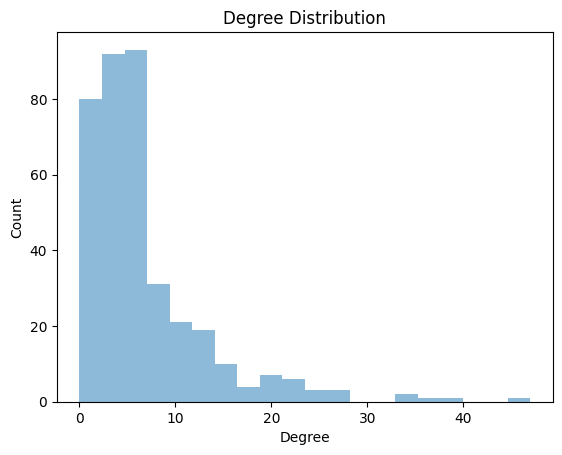

Statistics for degree:
  Minimum: 0
  Maximum: 47
  Average: 6.764705882352941
Statistics for degree centrality:
  Minimum: 0.0
  Maximum: 0.1260053619302949
  Average: 0.018135940703359003
Statistics for betweenness:
  Minimum: 0.0
  Maximum: 0.11740266696539056
  Average: 0.005692021527266815
Statistics for closeness:
  Minimum: 0.0
  Maximum: 0.40690911822043996
  Average: 0.27195340911127863
Statistics for average path length:
3.353693952449338
Statistics for longest path length:
9
Statistics for diameter:
inf
Statistics for number of edges:
1265


C:\Users\jaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ndlib\models\DiffusionModel.py:120: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')


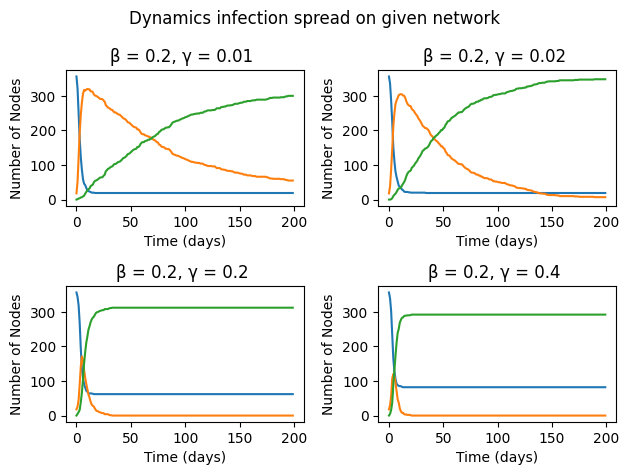

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1018]:
filename = 'transmission_network.csv'
graph = read_data(filename)

initial_infected = list(sorted(graph.nodes))[100:105]
plot_graph(graph, initial_infected)
statistics = get_graph_statistics(graph)

# Print statistics for each centrality measure
for centrality, stats in statistics.items():
    print_statistics(centrality, stats)

np.random.seed(0)
# Define the different initial values to compare
initial_SIR= [500, 1, 0]
beta_gamma = [
    [0.2, 0.01],
    [0.2, 0.02],
    [0.2, 0.2],
    [0.2, 0.4]
    ]


N_iterations = 200
fig, axes = plt.subplots(2, 2)

for i in range(len(beta_gamma)):
    beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
    model, iterations = infect_network(graph, beta, gamma, N_iterations, initial_infected)
    ax = axes[i//2, i%2]
    plot(model, iterations, ax)
    ax.set_title(f"β = {beta}, γ = {gamma} ")

fig.suptitle("Dynamics infection spread on given network")
fig.tight_layout()
plt.show()